In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = sio.loadmat('kos_doc_data.mat')

A = data['A']
B = data['B']
V = data['V']

W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])   # total no of vocabs
M = W

## Bayesian Inference on global $\beta_m$ using $Dir(\gamma)$

### Construct array of vocab counts, ordered according to vocab IDs.

In [2]:
train_vocab_IDs = np.unique(A[:, 1])
vocab_counts_IDorder = np.zeros(W)


for vocab_m in train_vocab_IDs:   # Start from 1 to 6906, with missing numbers in between.
        
    vocab_m_indices = np.where(A[:,1] == vocab_m)
    
    c_m = np.sum(A[vocab_m_indices, 2].T)
    
    vocab_counts_IDorder[vocab_m - 1] = c_m   # "count of vocab m across all docs in A"

# There are 271898 words in entire train set.

# Try adding scalar `gamma` to each element in array `vocab_counts_IDorder`.
print(vocab_counts_IDorder)
gamma = 1
print(vocab_counts_IDorder + gamma)

[ 4. 17. 13. ... 17. 32.  6.]
[ 5. 18. 14. ... 18. 33.  7.]


### You shouldn't sample $\underline{\beta}$ from its posterior prob $p(\beta|D, \alpha)$.
### Instead, obtain the predictive mean of $\underline{\beta}$ through the vocab counts and pseudo counts.

In [3]:
gamma = 0.1   # shape parameter for Dir of beta (global word prob).


# Don't do sampling.
'''
# samples from posterior prob of beta_ given training data (counts of vocab m).
beta_m_unnorm = np.random.gamma(vocab_counts_IDorder + gamma)
beta_m_norm = beta_m_unnorm/np.sum(beta_m_unnorm)

# Sanity check: Summing all beta_m should give unity. [Test passed]
# print(np.sum(beta_m_norm))
'''

# Calculate the predictive mean of each beta_m directly.
beta_post_mean = vocab_counts_IDorder + gamma
beta_post_mean = beta_post_mean / np.sum(beta_post_mean)
print(beta_post_mean)

# Sanity check: Summing all beta_m should give unity. [Test passed]
# print(np.sum(beta_post_mean))

np.save('results/b/BI_beta_IDorder(gamma='+str(gamma)+').npy', beta_post_mean)

[1.50409812e-05 6.27318971e-05 4.80577691e-05 ... 6.27318971e-05
 1.17759877e-04 2.23780452e-05]


### Plot histogram of 20 largest predictive $\beta_m$.

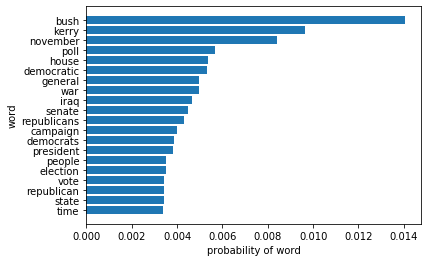

In [4]:
# Sort beta_m according to prob.

i_ascending_order = np.argsort(beta_post_mean)   # minus sign gives descending order.

beta_ascending_order = beta_post_mean[i_ascending_order]


num=20

y_pos = np.linspace(1, num, num)

plt.barh(y_pos, beta_ascending_order[-num:])

vocab_names = [ name[0][0] for name in V[i_ascending_order[-num:]] ]

plt.yticks(y_pos, vocab_names)

plt.xlabel('probability of word')
plt.ylabel('word')

plt.show()

### Combine histograms from maximum likelihood and bayesian inference to ease comparison.

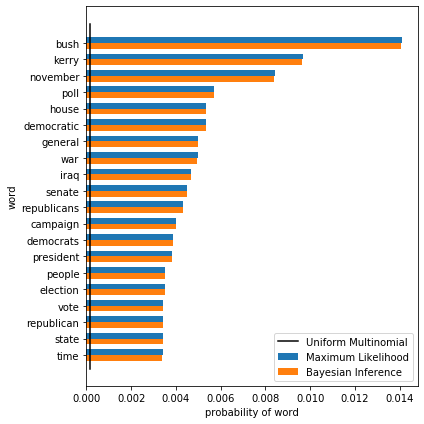

In [5]:
# Loading data from maximum likelihood

# beta_m are ordered according to magnitude.
ML_beta = np.load('results/a/ML_beta.npy')
ML_vocab_names = np.load('results/a/ML_vocab_names.npy')

# ----------------------------------------------------------------------

num=20

y_pos = np.linspace(1, num, num)
height = 0.35

plt.figure(figsize=(6,6))

plt.barh(y_pos, ML_beta[-num:], height, label='Maximum Likelihood')
plt.barh(y_pos - height, beta_ascending_order[-num:], height, label='Bayesian Inference')

plt.plot([1/M]*(num+2), np.linspace(0, num+1, num+2), 'k', label='Uniform Multinomial')

plt.legend()

vocab_names = [ name[0][0] for name in V[i_ascending_order[-num:]] ]

# hack: use `vocab_name` rather than that and `ML_vocab_names[-num:]` because they are the same.
# Check:  [Test passed]
# print(vocab_names == ML_vocab_names[-num:])

plt.yticks(y_pos - height/2, vocab_names)

plt.xlabel('probability of word')
plt.ylabel('word')

plt.tight_layout()
plt.savefig('results/a/ab_beta_max20(gamma='+str(gamma)+').png')

^ Notice all 20 maximum $\beta_m$ in Bayesian Inference have smaller values than Maximum Likelihood.

This is because the missing probability masses have been allocated to the vocabs with zero observed counts ($c_m = 0$).

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


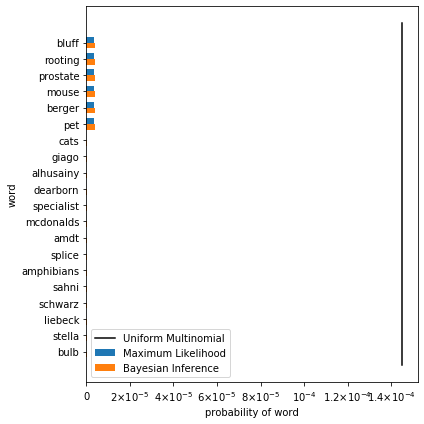

In [6]:
# Check if the missing prob masses have really been allocated this way.
import matplotlib.ticker as mticker

num=20

y_pos = np.linspace(1, num, num)
height = 0.35

plt.figure(figsize=(6,6))

plt.barh(y_pos, ML_beta[:num], height, label='Maximum Likelihood')
plt.barh(y_pos - height, beta_ascending_order[:num], height, label='Bayesian Inference')

plt.plot([1/M]*(num+2), np.linspace(0, num+1, num+2), 'k', label='Uniform Multinomial')

plt.legend()

vocab_names = [ name[0][0] for name in V[i_ascending_order[:num]] ]

# hack: use `vocab_names` rather than that and `ML_vocab_names[num:]` because they are the same.
# Check:  [Test passed]
print(vocab_names == ML_vocab_names[:num])


plt.yticks(y_pos - height/2, vocab_names)

plt.xlabel('probability of word')
plt.ylabel('word')

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(g))

plt.tight_layout()
plt.savefig('results/a/ab_beta_min20(gamma='+str(gamma)+').png')